In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using Plots, Statistics, DelimitedFiles

In [3]:
using CUDA
CUDA.device!(1)
CUDA.allowscalar(false)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm");

In [5]:
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [6]:
fam = "PF00684"
open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
fam = "PF00397"
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [7]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(22, 52, 59696)

# -------------- one sequence, one epsilon --------------

In [55]:
idx0 = rand(1:M)

34358

In [56]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = ---EWVQGLSPE-GYTYYYNTKTGESQWEKP
PKLETKEWVQGLSPEGYTYYYNTKTGESQWEKPKGFQG


38

In [57]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=38 q=21 size=1.619 MiB]

In [58]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -2.5
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [59]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=38 ongpu=true size=48.523 MiB]

In [60]:
##find ground state
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);



beta = 0.0f0
converged: err=0.000991717, tol=0.001, nbiter=61
(polar, energy) = (0.04085586f0, 39.863914f0)
beta = 0.1
converged: err=0.00097598135, tol=0.001, nbiter=41
(polar, energy) = (0.05352129f0, 24.374535f0)
beta = 0.2
converged: err=0.000985682, tol=0.001, nbiter=46
(polar, energy) = (0.076137125f0, 2.0826416f0)
beta = 0.30000000000000004
converged: err=0.000988692, tol=0.001, nbiter=173
(polar, energy) = (0.21253641f0, -42.323048f0)
beta = 0.4
converged: err=0.0009859204, tol=0.001, nbiter=211
(polar, energy) = (0.81167585f0, -55.465733f0)
beta = 0.5
converged: err=0.0009827912, tol=0.001, nbiter=70
(polar, energy) = (0.89168435f0, -55.465733f0)
beta = 0.6
converged: err=0.0009956062, tol=0.001, nbiter=67
(polar, energy) = (0.9250766f0, -57.64539f0)
100.913862 seconds (40.77 M allocations: 2.121 GiB, 2.08% gc time, 17.80% compilation time)


In [61]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(S_ϵ)

(0.6, 0.0009956062f0, 0.9250766f0, -57.64539f0, 0, -52.2823f0, 0.14502954790669106, 1.156073729322037)

In [62]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


sum(c) = 0


-57.64539f0

In [63]:
U_ϵ, energy_ϵ, energy_vit

(-52.2823f0, -57.64539f0, -57.64539f0)

In [64]:
t_vit = zeros(size(bel_ϵ[:,:,:]))
t_maxP = zeros(size(bel_ϵ[:,:,:]))
for i=1:L
    n,x = xnsol_vit[i]
    t_vit[x+1, n+1, i] = 1.0
    n,x = xnsol_ϵ[i]
    t_maxP[x+1, n+1, i] = 1.0
end

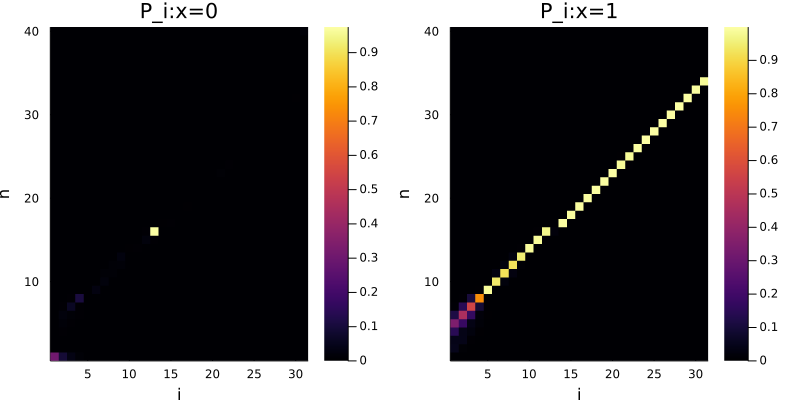

In [65]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
p = plot(p0, p1, size=(800,400))

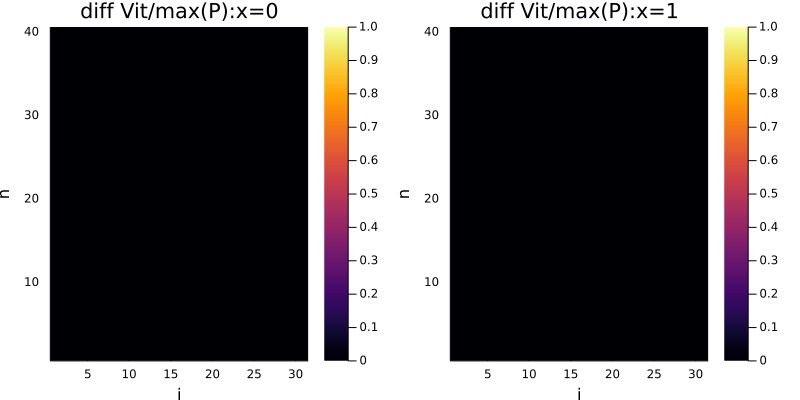

In [66]:
p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
plot(p2,p3, size=(800,400))

# Sampling with Viterbi

In [67]:
diffE_Vsamps_o = diffE_Vsamps
dists_Vsamps_o = dists_Vsamps;

In [68]:
ntrials = 5000
dists_Vsamps = []
diffE_Vsamps = []
xnsols_SAMP = []
for i in 1:ntrials
    xnsol_sampled = BpAlignGpu.viterbi_sampling(af, pm);
    dist = sum(xnsol_vit .!= xnsol_sampled)
    seqsol_samp = BpAlignGpu.convert_soltosequence!(xnsol_sampled, seq.strseq, N, L)
    energy_samp = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_samp[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    diffE = energy_samp - energy_vit
    append!(dists_Vsamps, dist)
    append!(diffE_Vsamps, diffE)
    append!(xnsols_SAMP, [xnsol_sampled])
    @show dist, diffE
end

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 9.206535f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (1, 11.607964f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 7.1974754f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (4, 12.075989f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 7.8761444f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 16.745945f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 5.9589043f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (2, 11.1464

(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (7, 14.838371f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (7, 11.796558f0)
(dist, diffE) = (6, 17.569f0)
(dist, diffE) = (3, 19.151482f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (8, 12.715244f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (4, 13.467625f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (3, 8.793072f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (2, 5.9589043f0)
(dist, diffE) = (2, 7.3866234f0

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 11.05999f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 9.392086f0)
(dist, diffE) = (1, 11.840054f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (2, 9.446671f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (5, 18.20261f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 7.1974754f0)
(dist, diffE) = (3, 15.224434f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 6.340149f0)
(dist, diffE) = (1, 11.840054f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (4, 8.66

(dist, diffE) = (4, 8.557446f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (3, 7.9900475f0)
(dist, diffE) = (2, 7.3973427f0)
(dist, diffE) = (4, 4.920204f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (1, 7.5399094f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 10.175655f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 7.3175583f0)
(dist, diffE) = (4, 8.18589f0)
(dist, diffE) = (5, 14.029903f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (2, 5.9589043f0)
(dist, diffE) = (4, 12.597866f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 8.6399765f0)
(dist, diffE) = (3, 8.575962f0)
(dist, diffE) = (3, 8.970692f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) =

(dist, diffE) = (2, 7.87236f0)
(dist, diffE) = (4, 8.794743f0)
(dist, diffE) = (3, 15.556274f0)
(dist, diffE) = (3, 15.87986f0)
(dist, diffE) = (4, 13.9506f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 7.3539124f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (4, 10.484013f0)
(dist, diffE) = (3, 9.75967f0)
(dist, diffE) = (4, 8.682583f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 13.992348f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (2, 9.951084f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (2, 7.0997925f0)
(dist, diffE) = (7, 20.604744f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 6.399082f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (6, 14.852604f0)
(d

(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (7, 14.838371f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 8.2607765f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 17.59832f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (8, 18.880577f0)
(dist, diffE) = (4, 16.522232f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (5, 16.130821f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.21426f0)
(dist, diffE) = (6, 12.198212f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (6, 14.302441f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 16.32806f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.3973427f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (6, 15.730877f0)
(dist, diffE) = (3,

(dist, diffE) = (5, 10.946251f0)
(dist, diffE) = (2, 7.39167f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 5.9589043f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (7, 24.61031f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.3973427f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (2, 7.009224f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (2, 7.9828835f0)
(dist, diffE) = (1, 7.8761444f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (3, 14.209747f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 9.632099f0)
(dist, diffE) = (4, 17.691921f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, di

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.0997925f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 9.951084f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 19.25328f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.39167f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (3, 22.604599f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (2, 7.390461f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 9.212997f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 5.045727

(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (8, 34.403893f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 14.052559f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.87236f0)
(dist, diffE) = (4, 8.557446f0)
(dist, diffE) = (3, 8.889027f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 12.511047f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 12.921413f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (2, 7.369854f0)
(dist, diffE) = (6, 16.765076f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 8.663353f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (6, 14.39584f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 19.377213f0)
(dist, diffE) = (5, 14.643494f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) 

(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 4.920204f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 13.170448f0)
(dist, diffE) = (3, 7.3175583f0)
(dist, diffE) = (1, 7.5555f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (6, 13.879684f0)
(dist, diffE) = (4, 7.788265f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (3, 9.361744f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 8.857132f0)
(dist, diffE) = (7, 18.248463f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (6, 11.354439f0)
(dist, diffE

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 21.527092f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 17.717548f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 8.414921f0)
(dist, diffE) = (2, 12.386322f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 16.255783f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (11, 24.534073f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 6.8847275f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (5, 15.622784f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 9.467537f0)
(dist, diffE) = (3, 4.919414

(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 6.9044495f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (3, 7.9900475f0)
(dist, diffE) = (4, 4.920204f0)
(dist, diffE) = (7, 15.367649f0)
(dist, diffE) = (3, 6.877159f0)
(dist, diffE) = (4, 13.376823f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (4, 14.604038f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (2, 5.9589043f0)
(dist, diffE) = (6, 18.208542f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (2, 9.532799f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (3, 29.687973f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 6.340149f

(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 10.814163f0)
(dist, diffE) = (4, 7.1974754f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 7.0997925f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 11.596596f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 8.793072f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 23.013721f0)
(dist, diffE) = (3, 7.1974754f0)
(dist, diffE) = (3, 6.877159f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (7, 17.862698f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (3, 9.99892f0)
(dist, diffE) = (5, 10.814163f0)
(dist, diffE) = (2,

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (6, 25.527557f0)
(dist, diffE) = (2, 3.8958511f0)
(dist, diffE) = (4, 11.26461f0)
(dist, diffE) = (6, 12.962807f0)
(dist, diffE) = (3, 16.674881f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (5, 13.341827f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (6, 10.673843f0)
(dist, diffE) = (4, 7.386898f0)
(dist, diffE) = (4, 7.1974754f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 9.406727f0)
(dist, diffE) = (5, 11.477791f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 4.9012604f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (5, 18.982738f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 10.109783f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (3, 12.514912f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (3, 6.877159f0)
(di

(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 7.8761444f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 17.085102f0)
(dist, diffE) = (3, 4.9194145f0)
(dist, diffE) = (3, 5.1995316f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (5, 9.627609f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (4, 10.180691f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (5, 12.875256f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 4.920204f0)
(dist, diffE) = (4, 4.752098f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 6.9044495f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = 

(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 4.920204f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 14.221313f0)
(dist, diffE) = (4, 9.405521f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (2, 7.6597176f0)
(dist, diffE) = (2, 4.5371246f0)
(dist, diffE) = (3, 8.818573f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (2, 4.760895f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (3, 3.6142159f0)
(dist, diffE) = (3, 3.2340126f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (2, 10.21101f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 7.5555f0)
(dist, diffE) = (4, 3.409317f0)
(dist, diffE) = (4, 2.867134f0)
(dist, diffE) = (0, 0.0f0)
(dist, diffE) = (1, 2.179657f0)
(dist, diffE) = (4, 8.630692f0)
(dist, diffE) = (4, 6.830078f0)
(dist, diffE) = (1, 5.045727f0)
(dist, diffE) = (3, 11.609684f0)
(dist, diffE) = (0, 0.0f0)
(dist,

In [69]:
diffE_Vsamps_o == diffE_Vsamps, dists_Vsamps_o == dists_Vsamps

(false, false)

In [70]:
length(xnsols_SAMP |> unique)

722

In [71]:
mean(dists_Vsamps), std(dists_Vsamps)

(2.2486, 1.9560069612980735)

In [72]:
mean(diffE_Vsamps), std(diffE_Vsamps)

(5.299189f0, 5.5767546f0)

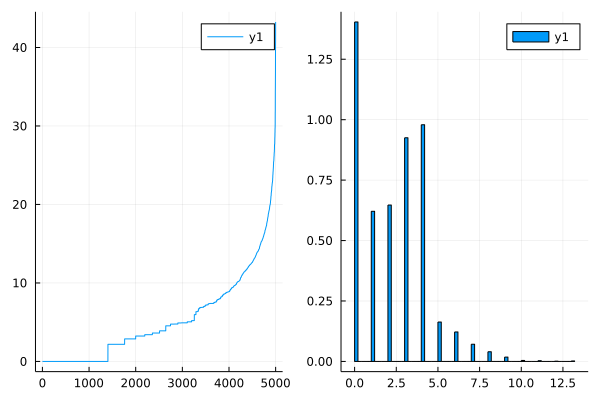

In [73]:
p1 = plot(sort(diffE_Vsamps,rev=false))
p2 = histogram(dists_Vsamps, bins = 100, normed = true)
p = plot(p1, p2)

In [74]:
paramrun = [fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]
results = [beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ]
x0 = [x[1] for x in xnsol_vit]
x1 = [x[2] for x in xnsol_vit]
xc = vcat(x0, x1);


In [75]:
namefile = "Viterbi_sampling_"*string(idx0)*".txt"
open(namefile, "a") do io
    writedlm(io, [idx0 al[idx0][1]])
    writedlm(io, [paramrun])
    writedlm(io, [results])
    writedlm(io, [xc])
    writedlm(io, [diffE_Vsamps])
    writedlm(io, [dists_Vsamps])
end    
